In [1]:
import numpy as np
import pandas as pd
import warnings
import re
from tqdm import tqdm_notebook
from collections import OrderedDict
from sklearn.metrics import f1_score, classification_report
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline

from dat2.tagger import Tagger, EnsembleClassifier
from dat2.util import label_vectors_to_string, print_messages_with_labels, LABELS

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

random_state = 777

In [49]:
turk_labels = joblib.load('./data/turk_labels.pkl')
prem_labels = joblib.load('./data/prem_labels.pkl')
turk_features = {}
prem_features = {}
feature_categories = ['char', 'all_tfidf', 'firstn_tfidf', 'infersent', 'wordvec', 'combined']

for category in feature_categories:
    turk_features[category] = joblib.load(''.join(('./data/turk_', category, '.pkl')))
    prem_features[category] = joblib.load(''.join(('./data/prem_', category, '.pkl')))
    
for category in feature_categories:
    print(category, 'feature length:', turk_features[category].shape[1])

char feature length: 12102
all_tfidf feature length: 1109
firstn_tfidf feature length: 264
infersent feature length: 4096
wordvec feature length: 300
combined feature length: 17871


In [3]:
def classification_report_to_df(report):
    rows = report.split('\n')
    fields = OrderedDict()
    split_avg = str.split(rows[-2])
    fields['avg-p'] = float(split_avg[3])
    fields['avg-r'] = float(split_avg[4])
    fields['avg-f1'] = float(split_avg[5])
    for row in rows[1:-2]:
        if row:
            split_row = str.split(row)
            fields['p-' + split_row[0]] = float(split_row[1])
            fields['r-' + split_row[0]] = float(split_row[2])
            fields['f1-' + split_row[0]] = float(split_row[3])
            fields['supp-' + split_row[0]] = int(split_row[4])
    return pd.DataFrame(data=fields, index=[0])

def filter_by_support(scores, threshold):
    for label in LABELS:
        supp_column_name = 'supp-' + label
        if scores[[supp_column_name]].values[0] < threshold:
            scores = scores.drop(
                [supp_column_name, 'p-' + label, 'r-' + label, 'f1-' + label],
                axis=1, errors='ignore')
    return scores

def f1_scores_only(scores):
    for label in LABELS:
        scores = scores.drop(['p-'+label, 'r-'+label, 'supp-'+label], axis=1, errors='ignore')
    return scores

In [23]:
classifiers = {
    'PolyKernelBalancedSVC': OneVsRestClassifier(
        SVC(
            kernel='poly',
            class_weight='balanced',
            random_state=random_state),
        n_jobs=-1),
    'RBFKernelBalancedSVC': OneVsRestClassifier(
        SVC(
            kernel='rbf',
            class_weight='balanced',
            random_state=random_state),
        n_jobs=-1),
    'LinearKernelBalancedSVC': OneVsRestClassifier(
        SVC(
            kernel='linear',
            class_weight='balanced',
            random_state=random_state),
        n_jobs=-1),
    
    'L1_ModhuberSGD': OneVsRestClassifier(
        SGDClassifier(
            loss='modified_huber',
            penalty='l1',
            class_weight='balanced', 
            random_state=random_state),
        n_jobs=-1),
    'L2_ModhuberSGD': OneVsRestClassifier(
        SGDClassifier(
            loss='modified_huber',
            penalty='l2',
            class_weight='balanced', 
            random_state=random_state),
        n_jobs=-1),
    'ElasticModhuberSGD': OneVsRestClassifier(
        SGDClassifier(
            loss='modified_huber',
            penalty='elasticnet',
            class_weight='balanced', 
            random_state=random_state),
        n_jobs=-1),
    
    'L1LogSGD': OneVsRestClassifier(
        SGDClassifier(
            loss='log', 
            penalty='l1',
            class_weight='balanced',
            random_state=random_state),
        n_jobs=-1),
    'L2LogSGD': OneVsRestClassifier(
        SGDClassifier(
            loss='log',
            penalty='l2',
            class_weight='balanced',
            random_state=random_state),
        n_jobs=-1),
    'ElasticLogSGD': OneVsRestClassifier(
        SGDClassifier(
            loss='log',
            penalty='elasticnet',
            class_weight='balanced',
            random_state=random_state),
        n_jobs=-1),

    'KNN-3': OneVsRestClassifier(
        KNeighborsClassifier(
            n_neighbors=3, 
            n_jobs=-1),
        n_jobs=-1),
    'KNN-5': OneVsRestClassifier(
        KNeighborsClassifier(
            n_neighbors=5,
            n_jobs=-1),
        n_jobs=-1),
    'KNN-7': OneVsRestClassifier(
        KNeighborsClassifier(
            n_neighbors=7,
            n_jobs=-1), 
        n_jobs=-1),
    
    'GaussianNB': OneVsRestClassifier(GaussianNB(), n_jobs=-1),
    'MultinomialNB': OneVsRestClassifier(MultinomialNB(), n_jobs=-1),
#     'HardVote': EnsembleClassifier(
#         [OneVsRestClassifier(LinearSVC()),
#          OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3)),
#          OneVsRestClassifier(SGDClassifier(loss='log', penalty='elasticnet'))],
#         voting='hard'),
#     'Stacking': EnsembleClassifier(
#         [OneVsRestClassifier(LinearSVC()),
#          OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3)),
#          OneVsRestClassifier(SGDClassifier(loss='log', penalty='elasticnet'))],
#         voting='stacking'),
    
}

/Users/bcserna/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [24]:
def evaluate_classifiers(classifiers=classifiers, features=feature_categories):
    feature_reports = {}
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)

        for f in tqdm_notebook(features, desc='Feature sets'):
            clf_reports = {}
            for clf_name in tqdm_notebook(classifiers, desc=''.join(['Classifiers', '(', f, ')']), leave=False):
                clf = classifiers[clf_name]
                clf.fit(X=turk_features[f], y=turk_labels)
                pred = clf.predict(prem_features[f])
                report = classification_report(prem_labels, pred, target_names=LABELS)
                report_df = classification_report_to_df(report)
                clf_reports[clf_name] = report_df
            feature_reports[f] = clf_reports
    return feature_reports

In [26]:
reports = evaluate_classifiers()

In [27]:
for clf_name in classifiers:
    print('\n', clf_name)
    for f in ['char', 'all_tfidf', 'firstn_tfidf', 'infersent', 'wordvec', 'combined']:
        print(f, reports[f][clf_name][['avg-f1']].values[0])


 PolyKernelBalancedSVC
char [ 0.25]
tfidf [ 0.28]
firstn [ 0.53]
infersent [ 0.66]
wordvec [ 0.69]
combined [ 0.65]

 RBFKernelBalancedSVC
char [ 0.52]
tfidf [ 0.56]
firstn [ 0.63]
infersent [ 0.69]
wordvec [ 0.71]
combined [ 0.68]

 LinearKernelBalancedSVC
char [ 0.52]
tfidf [ 0.59]
firstn [ 0.64]
infersent [ 0.63]
wordvec [ 0.63]
combined [ 0.63]

 L1_ModhuberSGD
char [ 0.57]
tfidf [ 0.58]
firstn [ 0.62]
infersent [ 0.67]
wordvec [ 0.62]
combined [ 0.7]

 L2_ModhuberSGD
char [ 0.56]
tfidf [ 0.58]
firstn [ 0.61]
infersent [ 0.6]
wordvec [ 0.64]
combined [ 0.66]

 ElasticModhuberSGD
char [ 0.59]
tfidf [ 0.59]
firstn [ 0.62]
infersent [ 0.65]
wordvec [ 0.61]
combined [ 0.61]

 L1LogSGD
char [ 0.58]
tfidf [ 0.58]
firstn [ 0.63]
infersent [ 0.69]
wordvec [ 0.65]
combined [ 0.7]

 L2LogSGD
char [ 0.57]
tfidf [ 0.59]
firstn [ 0.61]
infersent [ 0.63]
wordvec [ 0.64]
combined [ 0.66]

 ElasticLogSGD
char [ 0.59]
tfidf [ 0.58]
firstn [ 0.6]
infersent [ 0.64]
wordvec [ 0.58]
combined [ 0.66]



## Evaluating with different portions of the data

In [6]:
min_df_combined_features, min_df_combined_labels \
= Tagger.load_feature_vectors('./data/min_df_combined_feature_vectors.pkl', './data/min_df_combined_labels.pkl')
min_df_turk_features, min_df_turk_labels \
= Tagger.load_feature_vectors('./data/min_df_turk_feature_vectors.pkl', './data/min_df_turk_labels.pkl')

In [8]:
scores = {e:[] for e in estimators}
portions_num = 30
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    for e in tqdm_notebook(estimators, desc='Estimators'):
        for i in tqdm_notebook(np.linspace(start=100, stop=min_df_combined_labels.shape[0], num=portions_num), desc='Portions', leave=False):
            i = int(i)
            ev = evaluate_model_df(
                estimators[e],
#                 feature_sets['Combined'][:i],
                min_df_combined_features[:i],
#                 labels[:i],
                min_df_combined_labels[:i],
                e,
                'Combined')
            avg_f_score = ev[['avg-f1']].values[0][0]
            scores[e].append((i, avg_f_score))

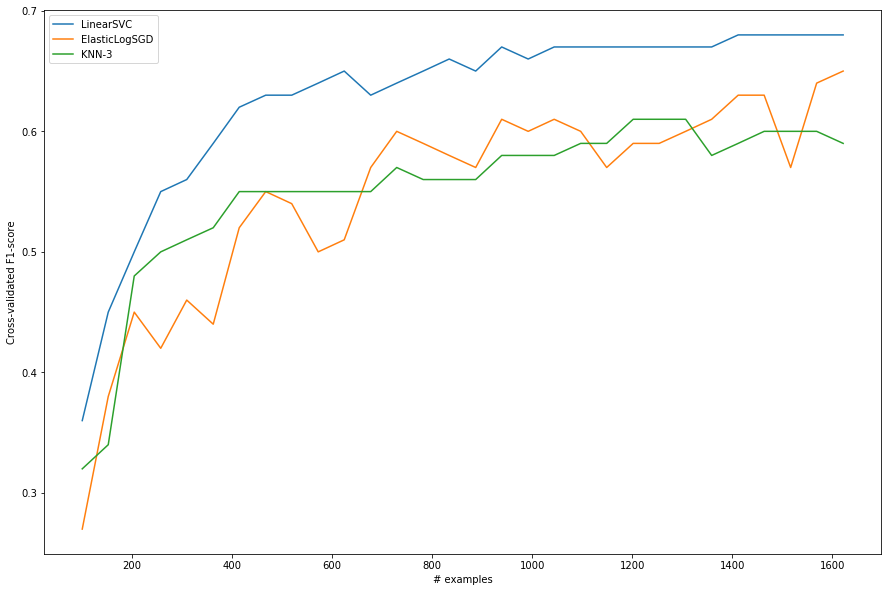

In [9]:
fig = plt.figure()
fig.set_size_inches(15, 10)
plt.xlabel('# examples')
plt.ylabel('Cross-validated F1-score')
for e in estimators:
    x = []
    y = []
    for x_, y_ in scores[e]:
        x.append(x_)
        y.append(y_)
    plt.plot(x, y, label=e)
plt.legend(loc='best')

## Testing models (trained on turk) with premium data

In [25]:
from sklearn.externals import joblib
# turk_data = joblib.load('./data/feature_vectors.pkl')
# turk_data = joblib.load('./data/min_df_turk_feature_vectors.pkl')
# turk_labels = joblib.load('./data/gold_labels.pkl')
# print(turk_data.shape, turk_labels.shape)
tagger = Tagger()
premium_messages = pd.read_csv('./data/premium_preprocessed.csv').MessageText.values
premium_messages = [pd.DataFrame({'MessageText': [m]}) for m in premium_messages]
print(len(premium_messages))
premium_vectors = tagger.extractor.generate_vectors(chats=premium_messages, fit=False)
print(premium_vectors.shape)
premium_labels = joblib.load('./data/labels_300.pkl')

198
(198, 1921)


In [14]:
premium_vectors = turk_scaler.transform(premium_vectors)

In [18]:
scores = {e:[] for e in estimators}
portions_num = 30
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    portion_preds = {}
    for e in tqdm_notebook(estimators, desc='Estimators'):
        for i in tqdm_notebook(np.linspace(start=100, stop=turk_data.shape[0], num=portions_num), desc='Portions', leave=False):
            i = int(i)
            estimator = OneVsRestClassifier(estimators[e]).fit(X=min_df_turk_features[:i], y=min_df_turk_labels[:i])
            pred = estimator.predict(premium_vectors)
            report_df = classification_report_to_df(classification_report(y_pred=pred,
                                                                          y_true=premium_labels,
                                                                          target_names=LABELS))
            fscore = report_df['avg-f1'].values[0]
            scores[e].append((i, fscore))

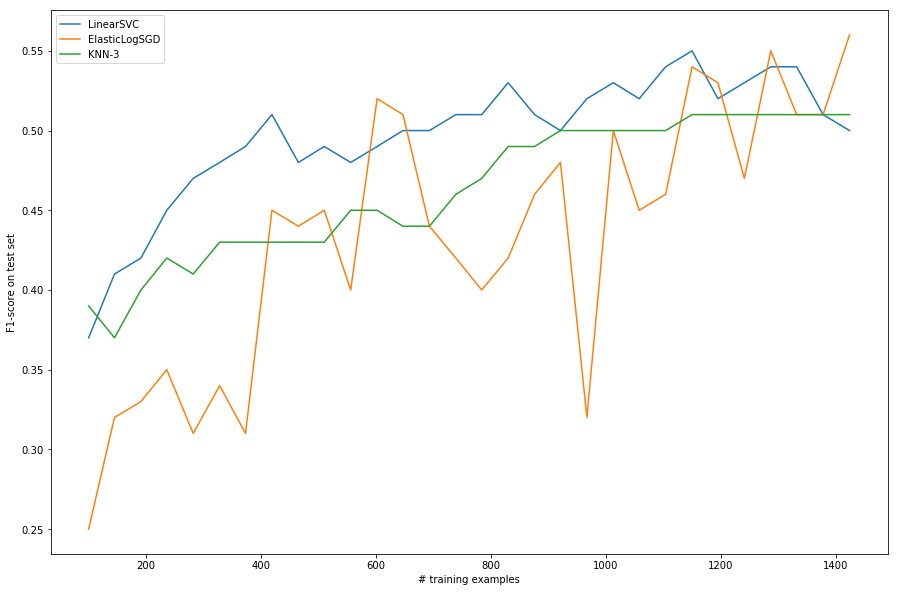

In [19]:
fig = plt.figure()
fig.set_size_inches(15, 10)
plt.xlabel('# training examples')
plt.ylabel('F1-score on test set')
for e in estimators:
    x = []
    y = []
    for x_, y_ in scores[e]:
        x.append(x_)
        y.append(y_)
    plt.plot(x, y, label=e)
plt.legend(loc='best')

# Voting classifier test

In [5]:
from dialog_act_tagger.ensemble import EnsembleClassifier

svm = OneVsRestClassifier(LinearSVC())
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))
sgd = OneVsRestClassifier(SGDClassifier(loss='log', penalty='elasticnet'))

simple_clfs = [
#     svm,
    knn,
    sgd
]

ec_hard = EnsembleClassifier(simple_clfs, voting='hard')
ec_hard.fit(min_df_turk_features, min_df_turk_labels)

ec_stack = EnsembleClassifier(simple_clfs, voting='stacking')
ec_stack.fit(min_df_turk_features, min_df_turk_labels)

classifiers = [
#     (svm, 'svm'),
    (knn, 'knn'),
    (sgd, 'sgd'),
    (ec_hard, 'ec_hard'),
    (ec_stack, 'ec_stack')
]

for clf, name in classifiers:
    pred = clf.predict(premium_vectors)
    scores = f1_score(premium_labels, pred, average='weighted')
    print(name, classification_report(premium_labels, pred, target_names=LABELS))

/Users/bcserna/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/bcserna/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcserna/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/bcserna/anaconda/lib/pytho

knn                               precision    recall  f1-score   support

                  Answer-Ack       0.56      0.29      0.38        17
                   Answer-No       0.00      0.00      0.00         2
                  Answer-Yes       0.71      0.36      0.48        14
            Greeting-Closing       0.57      0.57      0.57         7
            Greeting-Opening       0.64      0.64      0.64        22
               Question-Open       0.69      0.39      0.50        28
              Question-YesNo       0.75      0.42      0.54        36
                Request-Help       0.00      0.00      0.00         1
                Request-Info       0.82      0.33      0.47        42
               Request-Other       0.00      0.00      0.00         1
           Socialact-Apology       0.00      0.00      0.00         1
        Socialact-Downplayer       0.75      0.25      0.38        12
         Socialact-Gratitude       0.92      0.63      0.75        35
         Statem

In [30]:
import torch

infersent = torch.load('./encoder/infersent.allnli.pickle',
                       map_location=lambda storage, loc: storage)

infersent.set_glove_path('./encoder/glove.840B.300d.txt')
infersent.build_vocab_k_words(K=100000)

/Users/bcserna/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Vocab size : 100000


In [31]:
turk_messages = pd.read_csv('./data/preprocessed_turk.csv').MessageText.values
turk_embeddings = infersent.encode(turk_messages)
premium_embeddings = infersent.encode(premium_messages)

In [32]:
infersent_svc = OneVsRestClassifier(LinearSVC())
infersent_svc.fit(turk_embeddings, min_df_turk_labels)

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1)

In [34]:
premium_pred = infersent_svc.predict(premium_embeddings)
f1_score(premium_labels, premium_pred, average='weighted')

/Users/bcserna/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcserna/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.6498969742800359